Reference array is : MYR_7.7_AU_10.0km_iasp91_0.6_corr_0.1_grid

###########################################
Output directory exists. It will be overwritted.

###########################################
2025-03-28T06:20:52.000000Z
Hypocenter index on the source grid: 1640
Beam file in : beam_0.5_2.0_AU.dat
loading other arrays
Beam file in : beam_0.5_2.0_EU.dat
Shift= [ 0 -1]
Corr= [1.         0.22071087]
Shifted beam shape: (2, 3200, 3400)
Shifted beam shape: (3200, 3400)
Shifted beam shape: (2, 3200, 4600)
Shifted beam shape: (3200, 4600)
Shifted beam shape: (3200, 4600)
(3200,)
shif is: 0
length is: 3400
shif is: -1
length is: 3400
(2, 3200, 3400)
(3200, 3400)
Maximum energy of the beam: 0.0
Size of STF: (3400,)
Size of STF: (3000,)
Size of the cumulative energy: (3200,)
Maximum energy of the cumulative energy: nan
Maximum energy of the beam: 0.0
Size of the peak energy: (150, 4)
Maximum energy of the peaks: nan


C:\Users\ajay6\AppData\Local\Temp\ipykernel_16512\1401677461.py:210: RuntimeWarning: invalid value encountered in divide
  stf_beam=stf_beam/np.max(stf_beam)
C:\Users\ajay6\AppData\Local\Temp\ipykernel_16512\1401677461.py:224: RuntimeWarning: invalid value encountered in divide
  cumulative_energy[:,2]=temp/np.max(temp)
C:\Users\ajay6\AppData\Local\Temp\ipykernel_16512\1401677461.py:244: RuntimeWarning: invalid value encountered in divide
  peak_energy[:,3]=peak_energy[:,3]/np.max(peak_energy[:,3])


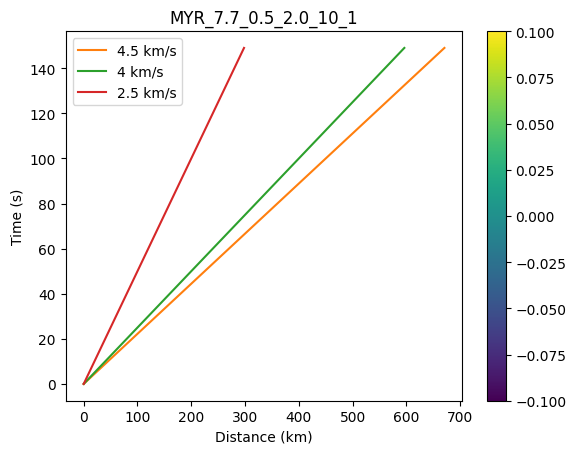

In [4]:
##########################################################################
# ADD SOME GENERAL INFO and LICENSE -> @ajay6763
##########################################################################
# Info: this script combines array where array output is specified by the directory name of the 
# of the array from previous step. The freqyency band of the arrays is read from the input files in the
# folders but if you want to change it you will have change the bp_l and bp_u parameteres.
# The output will be saved in the ./comnbined folder. 
# To do: 1. add command line option for this.
#        2. add command line option for output directory
#        3. add option for plotting    
from __future__ import division
import sys,os,time
import obspy
from obspy.geodetics import locations2degrees
from obspy.geodetics.base import gps2dist_azimuth
import pygmt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
########### 
import bp_lib as bp_lib
def moving_average(x, w):
    """
    Computes the moving average of a 2D numpy array x with a window size of w.
    """
    return np.convolve(x, np.ones(w), 'same') / w
color_list=['red','blue','green','magenta','cyan','yellow','black','white']
corr_window=10 # seconds
scale=5 #
peak_scale=8
array_list = ['MYR_7.7_AU_10.0km_iasp91_0.6_corr_0.1_grid', 'MYR_7.7_EU_10.0km_iasp91_0.6_corr_0.1_grid']
ref_array=array_list[0]
print('Reference array is :',ref_array)
'''
if len(array_list)>2:
     pass
else:
    print('You did not provide required input.\n')
    print('To run this script you should provide folder names of the arrays you would like to combine.\n')
    print('e.g., python bp_combine_arrays.py folder_1 folder_2\n')
    print('These folder should contain outputs for the each array for a same source grid and same frequency band.\n')
    print('You can also provide the frequency by adding')
    exit()
'''

outdir ='./combined' #str(Event)+'_'+str(Exp_name)
path = os.getcwd()
isExist = os.path.exists(outdir)
if not isExist:
            print('\n###########################################')
            print('Output directory does not exist. Making one for you.')
            print('\n###########################################')
            os.makedirs(outdir)
else:
            print('\n###########################################') 
            print('Output directory exists. It will be overwritted.')
            print('\n###########################################')
input = pd.read_csv('./'+ref_array+'/input.csv',header=None)
a=input.to_dict('series');keys = a[0][:];values = a[1][:]
res = {}
for i in range(len(keys)):
        res[keys[i]] = values[i]
#################################################################
# bp info
## BP parameters from the input file
bp_l                = 0.5 #float(res['bp_l']) #Hz
bp_u                = 2.0 #float(res['bp_u'])   #Hz
smooth_time_window  = int(res['smooth_time_window'])   #seconds
smooth_space_window = int(res['smooth_space_window'])
stack_start         = int(res['stack_start'])   #in seconds
stack_end           = int(res['stack_end'])  #in seconds
STF_start           = int(res['STF_start'])
STF_end             = int(res['STF_end'])
sps                 = int(res['sps'])  #samples per seconds
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])
#smooth_time_window=4
#smooth_space_window=1
#STF_start=0
#STF_end=40
#stack_start=30
#stack_end=70
#bp_l=0.8
#bp_u=5
##########################################################################
# Event info
Event=res['Event']
Array_name=res['Array_name']
event_lat=float(res['event_lat'])
event_long=float(res['event_long'])
event_depth=float(res['event_depth'])
#Array_name=res['Array_name']
#Exp_name=res['Exp_name']
origin_time=obspy.UTCDateTime(int(res['origin_year']),int(res['origin_month']),
             int(res['origin_day']),int(res['origin_hour']),int(res['origin_minute']),float(res['origin_seconds']))
print(origin_time)
Focal_mech = dict(strike=float(res['event_strike']), dip=float(res['event_dip']), rake=float(res['event_rake'])
                 , magnitude=float(res['event_magnitude']))
model               = obspy.taup.TauPyModel(model=str(res['model']))
sps                 = int(res['sps'])  #samples per seconds
source_grid_size    = float(res['source_grid_size']) #degrees
source_grid_extend_x  = float(res['source_grid_extend_x'])   #degrees
source_grid_extend_y  = float(res['source_grid_extend_y'])   #degrees
source_depth_size   = float(res['source_depth_size']) #km
source_depth_extend = float(res['source_grid_extend']) #km
#stream_for_bp=obspy.read('./Turky_7.6_all/stream.mseed')
#slong,slat          = bp_lib.make_source_grid(event_long,event_lat,source_grid_extend,source_grid_size)
slong,slat          = bp_lib.make_source_grid_hetero(event_long,event_lat,source_grid_extend_x,source_grid_extend_y,source_grid_size)

name=str(Event)+'_'+str(bp_l)+'_'+str(bp_u)

##############################
# Finding index of the hypocentral grid
dist=[]
for i in range(len(slat)):
        dist.append(((slat[i]-event_lat)**2 + (slong[i]-event_long)**2 )**0.2);
hypocentre_index=np.argmin(dist)
print('Hypocenter index on the source grid:',hypocentre_index)
### Load reference array beam
# Loading reference array
ref_stations_file = str(res['stations'])
beam_file='beam_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.dat'
print('Beam file in :',beam_file)
ref_array_beam = np.loadtxt('./'+ref_array+'/'+beam_file)
stream_info = np.load('./'+ref_array+'/array_bp_info.npy',allow_pickle=True)
ref_stream_for_bp=obspy.read('./'+ref_array+'/stream.mseed') 
stream_for_bp=bp_lib.populate_stream_info(ref_stream_for_bp,stream_info
                                          ,origin_time,event_depth,model)

### making master beam of size no_of_array,shape(beam): p,m,n
m,n=np.shape(ref_array_beam)
p=len(array_list)
beam_all = np.zeros((p,m,n),dtype=float)
beam_all[0]=ref_array_beam
hypo_stack=np.zeros((p,len(beam_all[0][hypocentre_index][:])))
print('loading other arrays')
for i in range(len(array_list)-1):
    input = pd.read_csv('./'+array_list[i+1]+'/input.csv',header=None)
    a=input.to_dict('series');keys = a[0][:];values = a[1][:]
    res = {}
    for j in range(len(keys)):
         res[keys[j]] = values[j]
    Array_name=res['Array_name']
    beam_file='beam_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.dat'
    print('Beam file in :',beam_file)
    ref_array_beam = np.loadtxt('./'+array_list[i+1]+'/'+beam_file)
    beam_all[i+1]=np.loadtxt('./'+array_list[i+1]+'/'+beam_file)
    hypo_stack[i+1]=beam_all[i+1][hypocentre_index][:]


# find correlation and shift for all arrays
corr=np.zeros(len(array_list),dtype=float)
shift=np.zeros(len(array_list),dtype=int)
corr[0]=1;shift[0]=0
for i in range(len(array_list)-1):
    cc = obspy.signal.cross_correlation.correlate(beam_all[0][hypocentre_index][:],
                                                  beam_all[i+1][hypocentre_index][:], corr_window*sps)
    shft, crr = obspy.signal.cross_correlation.xcorr_max(cc)
    shft = shft/sps
    corr[i+1]=crr
    shift[i+1]=shft
print('Shift=',shift)
print('Corr=',corr)

## shift the beam
p,m,n=np.shape(beam_all)
l=int((stack_end-stack_start)*sps)
st=int(stack_start*sps)
end=int(stack_end*sps)
beam_all_shifted=np.zeros((p,m,end-st),dtype=float)
print('Shifted beam shape:',np.shape(beam_all_shifted))
print('Shifted beam shape:',np.shape(beam_all_shifted[0]))
print('Shifted beam shape:',np.shape(beam_all))
print('Shifted beam shape:',np.shape(beam_all[0]))
print('Shifted beam shape:',np.shape(beam_all[0][shift[0]:shift[0]+int((end-st))][:]))
print(np.shape(slat))    
for i in range(len(array_list)):
     print('shif is:',shift[i])
     print('length is:',end-st)
     beam_all_shifted[i,:]=beam_all[i,:,shift[i]+st:shift[i]+int((end))]*corr[i]
# Preparing the beam i.e. getting the power
# Smoothening the beam
#beam_use=np.zeros((len(slat),(stack_end-stack_start)*sps-1))
beam_sum = np.sum(beam_all_shifted,axis=0)
print(np.shape(beam_all_shifted))
print(np.shape(beam_sum))
np.array_equal(beam_sum,beam_all_shifted[0])
np.array_equal(beam_all_shifted[1],beam_all_shifted[0])

stack_end=STF_end
stack_start=STF_start # stack start is at 0 because individaul arrays are already shited based on stack_start
beam_use=np.zeros_like(beam_sum)
m,n=np.shape(beam_use)
#space
for i in range(m):
    beam_use[:][i]=moving_average(beam_use[:][i],smooth_space_window)
#time
for i in range(m):
    beam_use[i][:]=moving_average(beam_use[i][:],smooth_time_window*sps)

beam_smoothened=np.square(beam_use)# /np.max(np.square(beam_use))
print('Maximum energy of the beam:',np.max(beam_smoothened))
################################
# getting the STF
stf_beam      = np.sum(beam_smoothened,axis=0)
print('Size of STF:', np.shape(stf_beam))
#Taking square becaouse we are interested in the power
#stf_beam=stf_beam**2
stf_beam=stf_beam[stack_start*sps:(stack_end)*sps]
stf_beam=stf_beam/np.max(stf_beam)
print('Size of STF:', np.shape(stf_beam))
stf_beam=np.column_stack((stf_beam,range(len(stf_beam))))
stf_beam[:,1]=stf_beam[:,1]/sps
plt.plot(stf_beam[:,1],stf_beam[:,0])
file_save    = 'STF_beam_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_'+str(smooth_time_window)+'_'+str(smooth_space_window)+'.dat'
np.savetxt(outdir+'/'+file_save,stf_beam,header='energy(normalized) time(s) ')  
###########################################
# Cumulative energy
beam_cumulative_use=beam_smoothened.T
temp     =np.sum(beam_cumulative_use[stack_start*sps:(stack_end)*sps],axis=0)
print('Size of the cumulative energy:',np.shape(temp))
m,n=np.shape(beam_smoothened)
cumulative_energy=np.zeros((m,3))
cumulative_energy[:,2]=temp/np.max(temp)
cumulative_energy[:,0]=slong
cumulative_energy[:,1]=slat
cumulative_energy[:,2]=cumulative_energy[:,2]/np.max(cumulative_energy[:,2])
file_save='cumulative_energy_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_'+str(smooth_time_window)+'_'+str(smooth_space_window)+'.dat'
np.savetxt(outdir+'/'+file_save,cumulative_energy,header='long lat energy(normalized)')
print('Maximum energy of the cumulative energy:',np.max(cumulative_energy[:,2]))
############################################################
# peak energy points
beam_peak_energy_use=beam_smoothened.T[stack_start*sps:(stack_end)*sps]
print('Maximum energy of the beam:',np.max(beam_peak_energy_use))
m,n=np.shape(beam_peak_energy_use)
peak_energy=np.zeros((int(m/sps),4))
print('Size of the peak energy:',np.shape(peak_energy))
for i in range(len(peak_energy)):
    ind              = np.argmax(beam_peak_energy_use[i*sps])
    peak_energy[i,0] = i
    peak_energy[i,1] = slong[ind]
    peak_energy[i,2] = slat[ind]
    peak_energy[i,3] = beam_peak_energy_use[i*sps][ind]
peak_energy[:,3]=peak_energy[:,3]/np.max(peak_energy[:,3])
print('Maximum energy of the peaks:',np.max(peak_energy[:,3]))
###############################################################
# rupture distance and velocity
dist_rupture=np.zeros(len(peak_energy)) # w.r.t to epicenter
dist_rupture2=np.zeros(len(peak_energy)) # w.r.st to the start of the peak
dist_rupture3=np.zeros(len(peak_energy)) # peak by peak
for i in range(len(dist_rupture)-1):
    dist_rupture[i]= np.sqrt(((peak_energy[i,1]-event_long)**2 + (peak_energy[i,2]-event_lat)**2))*(111)
    dist_rupture2[i]= np.sqrt(((peak_energy[i,1]-peak_energy[0,1])**2 + (peak_energy[i,2]-peak_energy[0,2])**2))*(111)
    dist_rupture3[i]= np.sqrt(((peak_energy[i+1,1]-peak_energy[i,1])**2 + (peak_energy[i+1,2]-peak_energy[i,2])**2))*(111)
peak_energy=np.column_stack((peak_energy,dist_rupture))
peak_energy=np.column_stack((peak_energy,dist_rupture2))
peak_energy=np.column_stack((peak_energy,np.cumsum(dist_rupture3)))

file_save='Peak_energy_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_'+str(smooth_time_window)+'_'+str(smooth_space_window)+'.dat'
np.savetxt(outdir+'/'+file_save,peak_energy,header='time(s) long lat energy(normalized) distance_wrt_epiceter(km) distance_peaks(km)')
plt.scatter(x=dist_rupture[:], y=peak_energy[:,0],s=peak_energy[:,3]*100,c=peak_energy[:,0])
plt.scatter(x=dist_rupture2[:], y=peak_energy[:,0],s=peak_energy[:,3]*100,c=peak_energy[:,0])
plt.title(str(name)+'_'+str(smooth_time_window)+'_'+str(smooth_space_window))
plt.scatter(x=dist_rupture2[:], y=peak_energy[:,0],s=peak_energy[:,3]*100,c=peak_energy[:,0])
plt.plot(4.5*peak_energy[:,0],peak_energy[:,0],label='4.5 km/s')
plt.plot(4*peak_energy[:,0],peak_energy[:,0],label='4 km/s')
plt.plot(2*peak_energy[:,0],peak_energy[:,0],label='2.5 km/s')
#plt.plot(1*peak_energy[st:end,0],peak_energy[st:end,0],label='1.0 km/s')
plt.xlabel('Distance (km)')
plt.ylabel('Time (s)')
plt.legend()
plt.colorbar()
#plt.savefig(outdir+'/'+str(name)+'_Rupture_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.png')




In [7]:
beam_smoothened

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
region=[event_long-source_grid_extend_x,event_long+source_grid_extend_x,event_lat-source_grid_extend_y,event_lat+source_grid_extend_y]
title="+t"+name+'_'+str(bp_l)+'-'+str(bp_u)+'Hz_T'+str(smooth_time_window)+'_Space'+str(smooth_space_window)
spacing=source_grid_size
fig = pygmt.Figure()
figsize=("9c", "8c")
proj="M?"
#########################################################################################################################################
# Plotting rupture map
#########################################################################################################################################
with fig.subplot(nrows=1, ncols=1, figsize=figsize, autolabel="a)",
    sharey=False,
    sharex=False,):
    energy_cmap=pygmt.makecpt(cmap="magma", series=[0.6, 1, 0.01])
    df = pygmt.blockmean(data=cumulative_energy, region=region, spacing=spacing)
    grd = pygmt.xyz2grd(data=df, region=region, spacing=spacing)
    fig.grdimage(grid=grd,cmap=energy_cmap,projection=proj, region=region, frame=["af", "WSne"],\
                 panel=[0, 0])
    fig.colorbar(frame=["a0.2", "x+lEnergy", "y+lrelative"])
    fig.coast(shorelines=True,frame=True,)
    #fig.plot(x=aftershock[:,1],y=aftershock[:,0],size=aftershock[:,3]/20,style='cc',fill = 'red',pen='black',)
    #fig.plot(x=aftershock['longitude'],y=aftershock['latitude'],projection=proj,region=region,size=aftershock['mag']/50,style='cc',fill = 'red',pen='black',transparency=60)
    try:
        fig.plot(x=aftershocks['Lon'],y=aftershocks['Lat'],size=aftershocks['Mag']/50,style='cc',fill = 'black',pen='black')#,transparency=0)
    except:
        pass
    fig.meca(spec=Focal_mech,projection=proj,region=region,scale="0.5c", longitude=event_long,latitude=event_lat,depth=event_depth,transparency=40,)
    peak_cmap=pygmt.makecpt(cmap="seis", series=[STF_start, STF_end,  (STF_end-STF_start)/10])
    fig.plot(x=peak_energy[STF_start:STF_end,1],y=peak_energy[STF_start:STF_end,2],projection=proj,region=region, \
             fill=peak_energy[STF_start:STF_end,0],cmap=True, \
         no_clip=True,size=peak_energy[STF_start:STF_end,3]/scale,style='cc', pen='0.5p,black',transparency=40,)
    #fig.plot(x=peak_energy[:,1],y=peak_energy[:,2],projection=proj,region=region, \
    #         fill=peak_energy[:,0],cmap=True, \
    #     no_clip=True,style='c0.1', pen='0.5p,black',transparency=40,)
    fig.colorbar(cmap=peak_cmap,position="jBL+o-2.0c/0.8c+v",box=False,frame=["x+lTime (s)"],scale=1,)
    fig.plot(x=event_long,y=event_lat,style= 'a0.5c',fill = 'blue',pen='black')
    #fig.legend()
#########################################################################################################################################
# Left, two subplots
# Move plot origin by 1 cm above the height of the entire figure
#########################################################################################################################################
fig.shift_origin(xshift="w+2c")
with fig.subplot(nrows=2, ncols=2, figsize=figsize, autolabel="b)", frame="a",
    sharey=False,
    sharex=False,
    margins=["0.4c", "0.4c"],):
#########################################################################################################################################
# Plotting STF
#########################################################################################################################################
    fig.basemap(
        region=[STF_start, STF_end, 0, 1], projection="X?", frame=["x+lTime (s)", "y+lAmplitude", str(title)], panel=[0, 0]
    )
    #fig.plot(x=STF_array[:,0],y=STF_array[:,1], pen='2p,black',)
    fig.plot(x=stf_beam[:,1],y=stf_beam[:,0], pen='2p,black',)
    #fig.plot(x=STF_array[:,0],y=STF_array[:,1], pen='2p,red',)
#########################################################################################################################################    
# Plotting Ruptuer velocity
#########################################################################################################################################
    peak_cmap=pygmt.makecpt(cmap="bilbao", series=[0, STF_end,  (STF_end-STF_start)/15])
    fig.basemap(
        region=[STF_start, STF_end,0, 4*STF_end ], projection="X?", frame=["x+lTime (s)", "y+lDistance (km)"], panel=[1, 0]
    )
    dist_x=5*peak_energy[STF_start:STF_end,0]
    fig.plot(y=dist_x,x=peak_energy[STF_start:STF_end,0], style= None,pen='0.5p,green',label='5 km/s')
    dist_x=4*peak_energy[STF_start:STF_end,0]
    fig.plot(y=dist_x,x=peak_energy[STF_start:STF_end,0], style= None,pen='0.5p,blue',label='4 km/s')
    dist_x=3*peak_energy[STF_start:STF_end,0]
    fig.plot(y=dist_x,x=peak_energy[STF_start:STF_end,0], style= None,pen='0.5p,red',label='3 km/s')
    fig.legend(position="jBR+o0.0c", box=False)
    fig.plot(y=dist_rupture,x=peak_energy[:,0],size=peak_energy[:,3]/scale,style='cc',fill = 'black',pen='black',
            transparency=40)
    fig.plot(y=dist_rupture2,x=peak_energy[:,0],size=peak_energy[:,3]/scale,style='sc',fill = 'red',pen='black',
            transparency=40)
    fig.plot(y=dist_rupture,x=peak_energy[:,0],size=peak_energy[:,3]/scale,style='cc',fill = 'blue',pen='black',
            transparency=40)

#########################################################################################################################################
# Plotting Traces
#########################################################################################################################################
    #fig.basemap(region=[0, STF_end+10, -1, len(stream_for_bp)], projection="X?", \
    #            frame=["x+lTime (s)", "y+lTrace"], panel=[0, 1],)
    #count=0
    scale=10
    fig.basemap(region=[-180, 180, stack_start, STF_end], panel=[0, 1],
    # set map width to 5 cm
    projection="P4c+a",
    # set the frame, color, and title
    # @^ allows for a line break within the title
    #frame=["xa45f10"],
    #frame=["xa45f", "+gbisque+tprojection='P5c' @^ region=[0, 360, 0, 1]"],
    )
    # looping through the arrays info
    for i in range(len(array_list)):
        # reading array info
        stream_info = np.load('./'+array_list[i]+'/array_bp_info.npy',allow_pickle=True)
        stream_for_bp=obspy.read('./'+array_list[i]+'/stream.mseed') 
        stream_for_bp=bp_lib.populate_stream_info(stream_for_bp,stream_info
                                          ,origin_time,event_depth,model)
        Ref_station_index=bp_lib.get_ref_station(stream_for_bp)
        ref_trace=stream_for_bp[Ref_station_index]
        stream_out=stream_for_bp.copy()
        for tr in stream_out:
            #tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
            st_time=tr.stats['P_arrival']+tr.stats['Corr_shift']-5
            end_time=st_time+stack_end
            tr.trim(st_time,end_time)
            tr.normalize()
            amp = tr.data*tr.stats['Corr_sign']  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            time = np.arange(0, len(amp)/ tr.stats.sampling_rate, tr.stats.delta)
            BAZ=np.zeros_like(amp)+tr.stats.Azimuth #baz[2]
            r_plot=BAZ+amp*scale
            fig.plot(x=r_plot,y=time,pen=str('0.25p,')+color_list[i+1],)
        # plotting reference tract
        #ref_trace.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
        st_time=ref_trace.stats['P_arrival']+ref_trace.stats['Corr_shift']-5
        end_time=st_time+stack_end
        ref_trace.trim(st_time,end_time)
        ref_trace.normalize()
        amp = ref_trace.data*ref_trace.stats['Corr_sign']  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
        time = np.arange(0, len(amp)/ ref_trace.stats.sampling_rate, ref_trace.stats.delta)
        BAZ=np.zeros_like(amp)+ref_trace.stats.Azimuth #baz[2]
        r_plot=BAZ+amp*scale
        fig.plot(x=r_plot,y=time,pen="0.5,red",)
    fig.meca(spec=Focal_mech,scale="0.3c",longitude=0,latitude=0,depth=event_depth)
        
#########################################################################################################################################
# Plotting Stations
#########################################################################################################################################
    projection='A'+str(event_long)+'/'+str(event_lat)+'/120/?'
    fig.basemap(
        region="g", projection=projection, frame=False,panel=[1,1],
    )
    # Plot the land as light gray, and the water as sky blue
    #fig.coast(shorelines=True)
    fig.coast(land="#666666", water="skyblue",)
    fig.meca(spec=Focal_mech,scale="0.4c",longitude=event_long,latitude=event_lat,depth=event_depth)
    # looping through the arrays info
    for i in range(len(array_list)):
        # reading array info
        stream_info = np.load('./'+array_list[i]+'/array_bp_info.npy',allow_pickle=True)
        stn_lat=stream_info[:,3].tolist()
        stn_long=stream_info[:,2].tolist()
        Ref_station_index=bp_lib.get_ref_station_frm_list(stn_long,stn_lat)
        fig.plot(x=stn_long[:],y=stn_lat[:],style='t0.2',fill = color_list[i+1],pen='black',)
        fig.plot(x=stn_long[Ref_station_index],y=stn_lat[Ref_station_index],\
                 style= 't0.2',fill = 'red',pen='black',)        
    '''
    for tr in stream_for_bp:
        sta_lat.append(tr.stats.station_latitude)
        sta_long.append(tr.stats.station_longitude)
    '''
    #fig.plot(x=sta_long,y=sta_lat,style='t0.2',fill = 'red',pen='black',)
    #fig.plot(x=sta_long[Ref_station_index],y=sta_lat[Ref_station_index],\
    #         style= 't0.2',fill = 'blue',pen='black',)
fig.show()
#fig.savefig(outdir+'/'+'T_Summary_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_T'+str(smooth_time_window)+'_Space'+str(smooth_space_window)+'.png',dpi=300)
fig.savefig(outdir+'/T_Summary_'+str(bp_l)+'_'+str(bp_u)+'_combined_T'+str(smooth_time_window)+'_Space'+str(smooth_space_window)+'.png',dpi=300)

#fig.savefig(outdir+'/'+'T_Summary_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.eps',dpi=300)

blockmean [WARNING]: No data records found; no output produced
subplot [ERROR]: No subplot information file!


GMTCLibError: Module 'subplot' failed with status code 15:
subplot [ERROR]: No subplot information file!